In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#read data
# test_set = np.loadtxt("mnist_test.csv",skiprows=1,delimiter=",")
# dataset = np.loadtxt("mnist_train.csv",skiprows=1,delimiter=",")

#
dataset = pd.read_csv("./mnist_train.csv", delimiter=',', nrows = 101)
# print(dataset.loc[0]) #Name: 0, Length: 785, dtype: int64
# print(dataset.loc[0][0]) #5
#input:dataset.loc[i][1:]
#truth:dataset.loc[i][0]

#can change to optimize
numLayer = 1
numNeu = 5
learn_rate = 0.1
epochs = 20
numWeight = 784*numNeu + numNeu*10 # only working when numLayer = 1
numOutputs = 10
numBias = numNeu + numOutputs

input_train = dataset[dataset.columns[1:]]
output_gt_val = dataset[dataset.columns[0]]

output_gt_set = np.zeros([100,10])
for i in range(100):
    for j in range(10):
        if j == output_gt_val[i]: 
            output_gt_set[i][j] = 1 
#print(output_gt_set)
def sigmoid(x):
  # Sigmoid activation function: f(x) = 1 / (1 + e^(-x))
  return 1 / (1 + np.exp(-x))

def deriv_sigmoid(x):
  # Derivative of sigmoid: f'(x) = f(x) * (1 - f(x))
  fx = sigmoid(x)
  return fx * (1 - fx)

def mse_loss(y_true, y_pred):
  # y_true and y_pred are numpy arrays of the same length.
  return ((y_true - y_pred) ** 2).mean()

class NeuralNet():
    def __init__(self):
        self.weight = {}
        self.bias = {}
        self.loss = {}
        self.output = np.zeros([100,10])
        self.output_sum = np.zeros([100,10])
        self.layer1 = np.zeros(numNeu)
        self.sum_layer1 = np.zeros(numNeu)
        self.dyp_dweight = np.zeros(10*numNeu)
        self.dhl_dweight = np.zeros(784*numNeu)
        self.dhl_dbias = np.zeros(numNeu+numOutputs)
        self.dyp_dbias = np.zeros(numOutputs)
        self.yp_hl = np.zeros(numNeu)
        self.deriv_ypred_each = np.zeros(10)
        
    
    def init_weights_and_bias(self):
        for i in range(numWeight):
            self.weight[i] = np.random.normal()

        for i in range(numBias):
            self.bias[i] = np.random.normal()
    
    def test(self, input):
        output = np.zeros(10)
        index_weight = 0
        for j in range(784):
            for k in range(numNeu):
                self.sum_layer1[k] += input[j]*self.weight[index_weight] + self.bias[k]
                index_weight+=1
    
        # sigmoid layer
        for ii in range(numNeu):
            self.layer1[ii] = sigmoid(self.sum_layer1[ii])
            
        #hidden layer1 to output
        for ii in range(10):
            for j in range(5):
                output[ii] += self.layer1[j] * self.weight[index_weight] + self.bias[ii+5]
            output[ii] = sigmoid(output[ii])
        return output

    def forward(self,input,output_gt_set):
        
        for epoch in range(epochs):

            print(epoch)
            # input to hidden layer1
            for i in range(100): #100 data len
                i_input = input_train.loc[i]
                index_weight = 0
                for j in range(784):
                    for k in range(numNeu):
                        self.sum_layer1[k] += i_input[j]*self.weight[index_weight] + self.bias[k]
                        index_weight+=1
            
                # sigmoid layer
                for ii in range(numNeu):
                    self.layer1[ii] = sigmoid(self.sum_layer1[ii])
                    
                #hidden layer1 to output
                for ii in range(10):
                    for j in range(5):
                        self.output_sum[i][ii] += self.layer1[j] * self.weight[index_weight] + self.bias[ii+5]
                    self.output[i][ii] = sigmoid(self.output_sum[i][ii])
                
                # dl/dw = dl/dyp * dyp/dh (hidden layer) * dh/dw
                # dl/db = dl/dyp * dyp/dh (hidden layer) * dh/db
                #mse loss
                
                diff = (self.output[i] - output_gt_set[i])
                dL_dypred = 2 * np.sum(diff)
                for j in range(10):
                    self.deriv_ypred_each[j] = self.output[i][j] - output_gt_set[i][j]

                #所有weight的index+1是 % 5 == 1 ==>  h0
                #               % 5 == 2 ==>  h1
                #               % 5 == 3 ==>  h2
                #               % 5 == 4 ==>  h3
                #               % 5 == 0 ==>  h4
                #          一共784轮
                
                # deriv weight input-hidden
                weight_index_bp = 0
                for j in range(784):
                    for k in range(numNeu):
                        if (k+1) % 5 == 1:
                            self.dhl_dweight[weight_index_bp] = i_input[j] * deriv_sigmoid(self.sum_layer1[0])
                        elif (k+1) % 5 == 2:
                            self.dhl_dweight[weight_index_bp] = i_input[j] * deriv_sigmoid(self.sum_layer1[1])
                        elif (k+1) % 5 == 3:
                            self.dhl_dweight[weight_index_bp] = i_input[j] * deriv_sigmoid(self.sum_layer1[2])
                        elif (k+1) % 5 == 4:
                            self.dhl_dweight[weight_index_bp] = i_input[j] * deriv_sigmoid(self.sum_layer1[3])
                        elif (k+1) % 5 == 0:
                            self.dhl_dweight[weight_index_bp] = i_input[j] * deriv_sigmoid(self.sum_layer1[4])
                        weight_index_bp += 1

                # deriv weight hidden-output
                weight_index_bp = 0
                for j in range(10):
                    for k in range(numNeu):
                        self.dyp_dweight[weight_index_bp] = deriv_sigmoid(self.output[i][j]) * self.layer1[k]
                        weight_index_bp += 1
                
                # deriv hidden-output yp_hl 
                # numNeu = 5
                weight_index_bp = numNeu * 784
                for k in range(10):
                    for j in range(numNeu):
                        self.yp_hl[j] = self.weight[weight_index_bp] * deriv_sigmoid(self.output_sum[i][k])
                        weight_index_bp += 1


                
                # deriv bias
                for j in range(numNeu):
                    self.dhl_dbias[j] = deriv_sigmoid(self.sum_layer1[j])
                
                for j in range(numOutputs):
                    self.dhl_dbias[j+numNeu] = deriv_sigmoid(self.output_sum[i][j])



                # update each weight
                # self.w1 -= learn_rate * d_L_d_ypred * d_ypred_d_h1 * d_h1_d_w1
                    # before hl
                #w0: in0->hl0
                #w1: in0->hl1
                #w2: in0->hl2
                ind = 0
                for j in range(784):
                    for k in range(numNeu):
                        self.weight[ind] -= learn_rate * dL_dypred *self.dhl_dweight[ind] * self.yp_hl[k]
                        ind += 1

                    # after hl
                    #self.w5 -= learn_rate * d_L_d_y1 * d_ypred_d_w5
                ind = 0
                for j in range(numNeu):
                    for k in range(10):
                        self.weight[ind+784*numNeu] -= learn_rate * self.deriv_ypred_each[k] * self.dyp_dweight[ind]
                        ind += 1

                # update each bias
                    #bias in hl self.b2 -= learn_rate * d_L_d_ypred * d_ypred_d_h2 * d_h2_d_b2
                for j in range(numNeu):
                    self.bias[j] -= learn_rate * dL_dypred * self.yp_hl[j] * self.dhl_dbias[j]
                #bias in yp self.b3 -= learn_rate * d_L_d_y1 * d_ypred_d_b3
                for j in range(numOutputs):
                    self.bias[j+numNeu] -= learn_rate * self.deriv_ypred_each[j] * self.dhl_dbias[j+numNeu]

                # def mse_loss(y_true, y_pred):
            print(mse_loss(output_gt_set,self.output))




                    

                







                
            
            





aa = NeuralNet()
aa.init_weights_and_bias()
print("fin")
print(output_gt_val)

aa.forward(dataset.loc[0:][1:],output_gt_set)

print(aa.test(input_train.values.tolist()[0]), output_gt_val[0])

# 1. forward
# 2. loss calcualte
# 3. bp
# 4. repeat



fin
0      5
1      0
2      4
3      1
4      9
      ..
96     7
97     8
98     3
99     1
100    5
Name: label, Length: 101, dtype: int64
0


/tmp/ipykernel_46064/3435187207.py:36: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


0.258853840835856
1
0.2341905903052774
2
0.19223125987078687
3
0.17743339433044444
4
0.17792255989024505
5
0.17798231314166912
6
0.17799513328354113
7
0.17799859969816134
8
0.1779995892228162
9
0.17799987833498795
10
0.17799996379073776
11
0.17799998919748372
12
0.17799999677328807
13
0.17799999903558317
14
0.17799999971165817
15
0.17799999991377718
16
0.17799999997421456
17
0.17799999999228833
18
0.17799999999769364
19
0.1779999999993102
[2.30227933e-01 8.58330165e-02 1.47346630e-01 1.68257340e-02
 1.22204231e-01 1.14225564e-01 9.97249081e-01 1.04908024e-02
 5.68132124e-04 1.74712352e-02] 5


In [2]:
print(aa.test(input_train.values.tolist()[0]), output_gt_val[0])

[0.47083978 0.76042087 0.00079617 0.42050592 0.04771674 0.67999765
 0.44681841 0.61897953 0.67143945 0.4582522 ] 5


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


In [3]:
print(aa.test(input_train.values.tolist()[1]), output_gt_val[1])

[0.47083978 0.76042087 0.00079617 0.42050592 0.04771674 0.67999765
 0.44681841 0.61897953 0.67143945 0.4582522 ] 0


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


In [12]:
for i in range(100):
    #print(input_train.values.tolist()[i])
    print(np.argmax(aa.test(input_train.values.tolist()[i])))
    


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9


torch.Size([20, 1, 28, 28]) torch.Size([20])


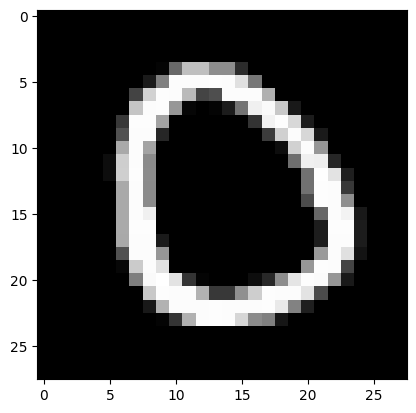

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

## 配置其他超参数，如batch_size, num_workers, learning rate, 以及总的epochs
batch_size = 20
num_workers = 4   # 对于Windows用户，这里应设置为0，否则会出现多线程错误
lr = 1e-4
epochs = 20

image_size = 28
data_transform = transforms.Compose([
    transforms.ToPILImage(),  
     # 这一步取决于后续的数据读取方式，如果使用内置数据集读取方式则不需要
    transforms.Resize(image_size),
    transforms.ToTensor()
])

class MDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.images = df.iloc[:,1:].values.astype(np.uint8)
        self.labels = df.iloc[:, 0].values
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape(28,28,1)
        label = int(self.labels[idx])
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = torch.tensor(image/255., dtype=torch.float)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

train_df = pd.read_csv("./dataset/part_of_mnist_train.csv")
test_df = pd.read_csv("./dataset/mnist_test.csv")

train_data = MDataset(train_df, data_transform)
test_data = MDataset(test_df, data_transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)


image, label = next(iter(train_loader))
print(image.shape, label.shape)
plt.imshow(image[5][0], cmap="gray")

In [6]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
dataset = pd.read_csv("./dataset/part_of_mnist_train.csv", delimiter=',', nrows = 20000)

input_train = dataset[dataset.columns[1:]]
output_gt_val = dataset[dataset.columns[0]]

In [12]:
pd.value_counts(output_gt_val[0:1000])

7    117
1    116
4    105
9    100
2     99
0     97
6     94
3     93
5     92
8     87
Name: label, dtype: int64

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")